## <center/> Digital Communication project 
<center/> Mahamat Hamid

In [55]:
from utils import *
import scipy.signal as sg 

In [27]:
L = 1000
F = 8
fe = 48e3
Ω =  3
β = 0.3
A = 1
Δ = 1
SNR = 15

m = np.random.randint(0, 2, (L,2))
d = bit2Symbol_Mapping_QPSK_Gray(A, m)
dech = seqSymbEch(d,F)

he = filterootcos(β,F,Ω)

s = np.convolve(he, dech)


Occupied band:  7.8 kHz


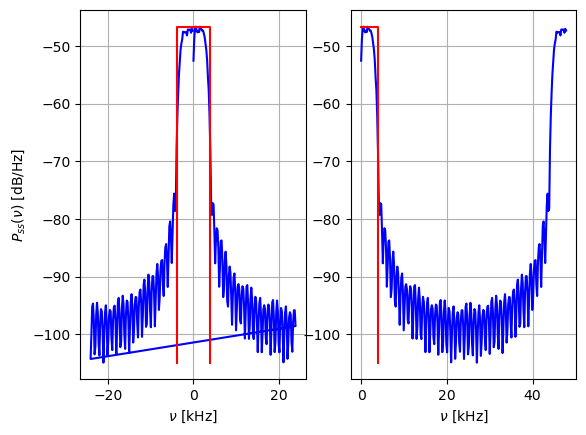

In [110]:
freq_u = 1e-3 # freq in kHz

# Power spectral density
freqs, val = sg.welch(s, fs=fe, return_onesided=False, scaling='density')

# Occupied band
B_occ = (1 + β) * fe/ F
print('Occupied band: ', B_occ * freq_u, 'kHz')

plt.subplot(1,2,1)
plt.plot(freqs * freq_u, 10 * np.log10(val), color='blue')
plt.xlabel(r'$\nu$ [kHz]')
plt.ylabel(r'$P_{ss}(\nu)$ [dB/Hz]')
max_psd = 10 * np.log10(np.max(val))
min_psd = 10 * np.log10(np.min(val))
x_f = (B_occ/2) * freq_u
plt.plot([-x_f, -x_f, x_f,x_f], [min_psd, max_psd, max_psd, min_psd], color='red', label='Occupied band')
plt.grid()

plt.subplot(1,2,2)
freqs[freqs < 0] = freqs[freqs < 0] + fe # Shift to have the negative frequencies at the end
plt.plot(freqs * freq_u, 10 * np.log10(val), color='blue')
plt.xlabel(r'$\nu$ [kHz]')
plt.plot([0, x_f,x_f], [ max_psd, max_psd, min_psd], color='red', label='Occupied band')
plt.grid()


In [118]:
num = int(np.floor(len(s_hr)/(3 * F)))
Z = np.empty((3 * F, num)).astype(complex)
for i in range(num):
    Z[:,i] = s_hr[i*3*F:(i+1)*3*F]


In [124]:
window_eye = (np.array([list(range(0,3*F)) for k in range(num)])).flatten()

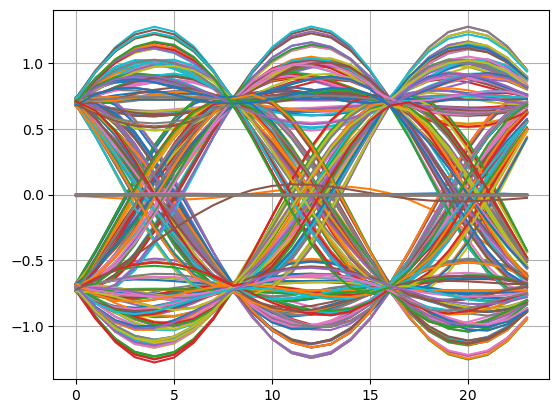

In [126]:
plt.plot(np.arange(0, 3*F), np.real(Z))
plt.grid()

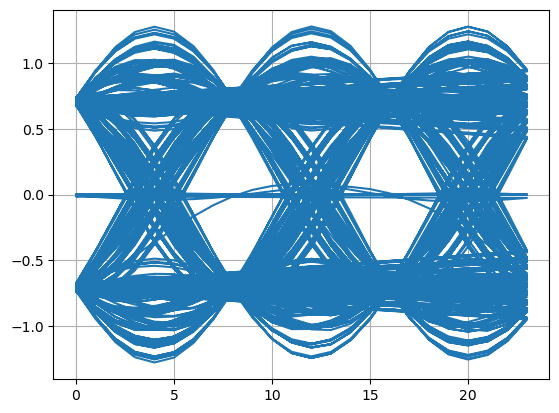

In [128]:
plt.plot(window_eye, np.real(s_hr))
plt.grid()

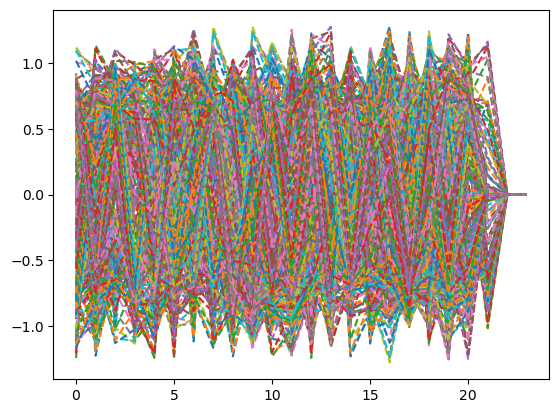

In [115]:
s_he = s
s_hr = np.convolve(s_he, he)
s_hr = s_hr[0 : int(np.floor(len(s_hr)/(3 * F))*3*F)]
Z = np.reshape(s_hr, (3*F, int(np.floor(len(s_hr)/(3 * F)))))
plt.plot(np.arange(0, 3*F), np.real(Z),'--')


d:\Logiciels\Anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


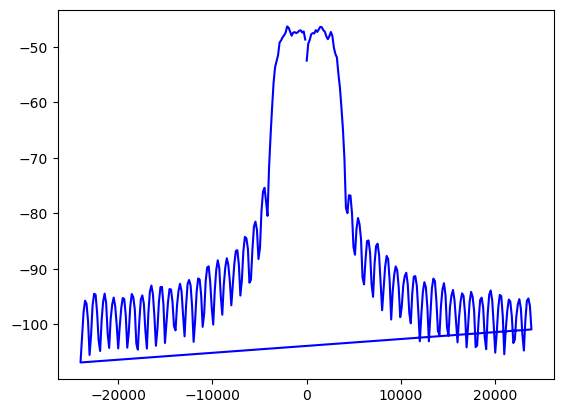

In [12]:
f, Pxx = 
plt.plot(f, 10 * np.log10(Pxx), color='blue')